In [1]:
import cv2
import pickle
import numpy as np
import pylab as plt

IMAGE_SIZE = (224, 224)

images = []
masks = []
graphs = []

for i in range(1000):
    try:
        graph = pickle.load(open(f'../data/Vegas/tile_{i}_graph.pickle', 'rb'))
        image = cv2.resize(cv2.imread(f'../data/Vegas/tile_{i}_8bit.tif'), IMAGE_SIZE)
        mask = cv2.resize(cv2.imread(f'../data/Vegas/tile_{i}_mask.tif', cv2.IMREAD_GRAYSCALE), IMAGE_SIZE)
    except Exception as e:
        print(e)
    else:
        graphs.append(graph)
        images.append(image)
        masks.append(np.where(mask == 150, 1.0, 0.0))

[Errno 2] No such file or directory: '../data/Vegas/tile_112_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_174_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_356_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_390_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_428_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_635_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_752_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_849_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_989_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_990_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_991_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_992_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_993_graph.pickle'
[Errno 2] No such file or

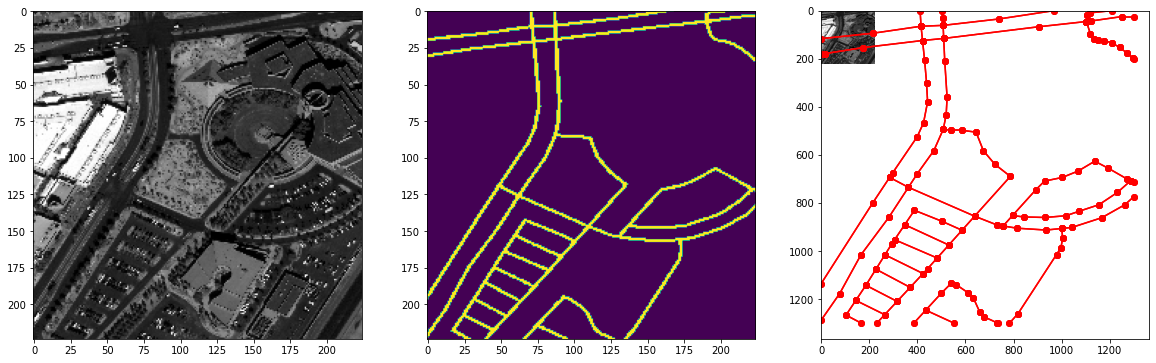

In [2]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

ax[0].imshow(images[0])
ax[1].imshow(masks[0])
ax[2].imshow(images[0])

for u, neighbours in graphs[0].items():
    for v in neighbours:
        ax[2].plot([u[0], v[0]], [u[1], v[1]], 'r')
        ax[2].scatter([u[0], v[0]], [u[1], v[1]], color='r')

In [3]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

In [11]:
import os
import re
from glob import glob

def read_images(folder='../data/Vegas/'):
    for image in glob(f'{folder}/*_8bit.tif'):
        match = re.fullmatch(r'\.\./data/Vegas/([a-zA-Z0-9_]*)_8bit\.tif', image)
        if not match:
            continue
        mask = f'../data/Vegas/{match[1]}_mask.tif'
        if not os.path.exists(mask):
            continue
        image = cv2.resize(cv2.imread(image), (1300, 1300))
        mask = cv2.resize(cv2.imread(mask, cv2.IMREAD_GRAYSCALE), (1300, 1300))
        yield image, np.where(mask == 150, 1.0, 0.0)
        
        
class HorizontalRandomFlip(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

    
dataset = tf.data.Dataset.from_generator(read_images,
                                        output_signature=(
                                            tf.TensorSpec(shape=(1300, 1300, 3), dtype=tf.float32),
                                            tf.TensorSpec(shape=(1300, 1300), dtype=tf.float32)
                                        )).cache()\
                                          .batch(16)\
                                          .repeat()\
                                          .map(HorizontalRandomFlip())\
                                          .prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [6]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

In [7]:
def unet_model():
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=2,
        padding='same', activation='sigmoid')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [14]:
def xception():
    inputs = tf.keras.layers.Input(shape=[1300, 1300, 3])
    
    base_model = tf.keras.applications.Xception(
        weights='imagenet',
        input_shape=(1300, 1300, 3),
        include_top=False)

    x = base_model(inputs)
    
    flatten = tf.keras.layers.Flatten()(x)
    prediction = tf.keras.layers.Dense(1300, activation='sigmoid')(flatten)
    reshaped = tf.keras.layers.Reshape((1300, 1300))(prediction)
    
    return tf.keras.Model(inputs, outputs)



model = xception()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

2022-04-26 15:13:16.276155: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.67GiB (rounded to 17901977600)requested by op RandomUniform
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-04-26 15:13:16.276231: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-04-26 15:13:16.276244: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 153, Chunks in use: 152. 38.2KiB allocated for chunks. 38.0KiB in use in bin. 10.9KiB client-requested in use in bin.
2022-04-26 15:13:16.276252: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 97, Chunks in use: 93. 62.0KiB allocated for chunks. 59.5KiB in use in bin. 51.9KiB client-requested in use in bin.
2022-04-26 15:13:16

ResourceExhaustedError: OOM when allocating tensor with shape[3442688,1300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [9]:
images = np.array(images)
masks = np.array(masks)

In [ ]:
model.fit(dataset, epochs=10, steps_per_epoch=80)

In [ ]:
images[0].shape

In [ ]:
pred_masks = model.predict(images[:10])

fig, ax = plt.subplots(10, 3, figsize=(13, 30))

for i in range(10):
    ax[i, 0].imshow(images[i])
    ax[i, 1].imshow(pred_masks[i])
    ax[i, 2].imshow(masks[i])